In [1]:
# Importing features
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

# Reading in the data
grid_fp = r'exercise-4-ohtonygren/data/MetropAccess_YKR_grid_EurefFIN.shp'
itis_fp = r'exercise-4-ohtonygren/data/TravelTimes_to_5944003_Itis.txt'
roads_fp = r'data/dataE5/roads.shp'
metro_fp = r'data/dataE5/metro.shp'

grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)
itis = pd.read_csv(itis_fp, sep=';', usecols=['pt_r_t', 'car_r_t', 'from_id', 'to_id'])

In [2]:
# Merging the data from the Myyrmanni shopping center and the MetroAccess reference grid
itis_geo = grid.merge(itis, left_on='YKR_ID', right_on='from_id')

# Replacing all the '-1' values with 'NaN' and using the dropna() function to drop them from the file
itis_geo = itis_geo.replace(-1, np.nan)
itis_geo = itis_geo.dropna()

In [3]:
print(grid.crs)
print(itis_geo.crs)
print(roads.crs)
print(metro.crs)

epsg:3067
epsg:3067
epsg:2392
epsg:2392


In [4]:
# Reproject geometries to EPSG 3857 (Web Mercator) based on the grid crs:
grid = grid.to_crs(epsg=3857)
itis_geo = itis_geo.to_crs(crs=grid.crs)
roads = roads.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)


In [5]:
# Checking that all projections match
roads.crs == grid.crs == metro.crs == itis_geo.crs

True

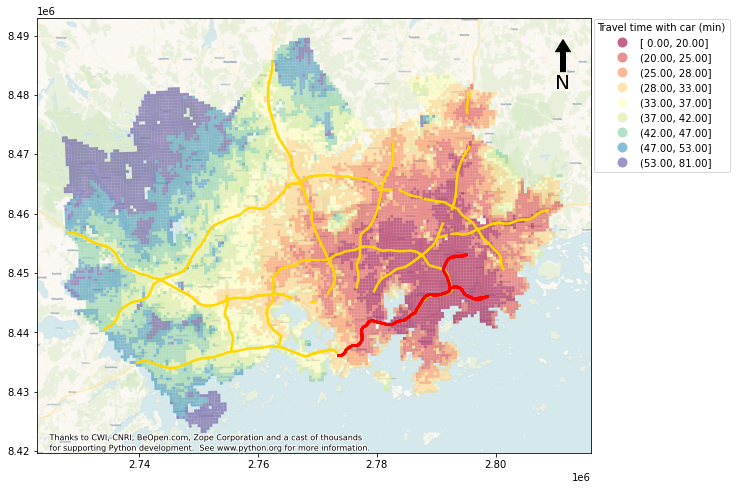

In [6]:
import contextily as ctx

# Creating one subplot, control figure size here
fig, ax = plt.subplots(figsize=(12,8))

# Visualize travel times
itis_geo.plot(ax=ax,
              column='car_r_t',
              cmap='Spectral',
              scheme='quantiles',
              k=9,
              alpha=0.6,
              legend=True)

# Adjust legend
ax.get_legend().set_bbox_to_anchor((1.26,1.01))
ax.get_legend().set_title('Travel time with car (min)')

# Adding North arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Add roads
roads.plot(ax=ax, color='gold', linewidth=2.5)

# Add metro
metro.plot(ax=ax, color='red', linewidth=2.5)

# Specify the style to use
style = "rastertiles/voyager"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style

# Add basemap
ctx.add_basemap(ax, source=cartodb_url, attribution=credits)

# Saving map as png
outfp = r'exercise-5-ohtonygren/docs/static_map.png'
plt.savefig(outfp, dpi=300)